# Usage

Here are some examples of how to use `topas2numpy` in an IPython notebook.

Before starting, we setup plotting with `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Reading ntuples

TOPAS ntuples store data in columns, with each row representing a different event in a particle's history. The exact details of what data is written to file and when this is triggered depends upon the scorer implementation.

`topas2numpy.read_ntuple()` allows us to read TOPAS ntuples in ASCII, binary and limited formats. It returns a [NumPy structured array](http://docs.scipy.org/doc/numpy-1.10.1/user/basics.rec.html).

Record arrays are not supported because TOPAS column name can contain characters that are illegal for attribute names. If desired, I can add this feature at the expense of changing column names.

Onwards to the example usage! First, we read in the data:

In [2]:
from topas2numpy import read_ntuple
x = read_ntuple('../tests/data/ascii-phasespace.phsp')

Next, we want to check what columns are available in this ntuple:

In [3]:
x.dtype.names

('Position X (cm)',
 'Position Y (cm)',
 'Position Z (cm)',
 'Direction Cosine X',
 'Direction Cosine Y',
 'Energy (MeV)',
 'Weight',
 'Particle Type (in PDG Format)',
 'Flag to tell if Third Direction Cosine is Negative (1 means true)',
 'Flag to tell if this is the First Scored Particle from this History (1 means true)')

Now we want to make a histogram of the energy of the protons contained in the ntuple. Note that the PDG code for protons is 2212.

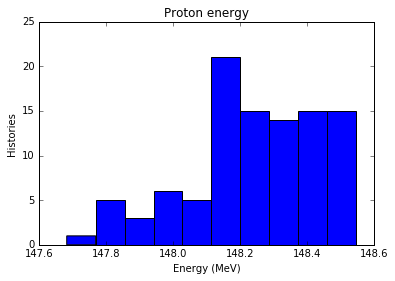

In [4]:
energy_label = 'Energy (MeV)'
species_label = 'Particle Type (in PDG Format)'

energy = x[energy_label]
species = x[species_label]
proton_energy = energy[species==2212]

n, bins, patches = plt.hist(proton_energy)
plt.xlabel(energy_label)
plt.ylabel('Histories')
plt.title('Proton energy')

## Reading binned results

TOPAS scorers can also accumulate quantities within binned geometry components. By default a sum is accumulated, but it is also possible to accumulate additional statistics such as the mean, standard deviation, etc.

As more metadata is available for binned scorers than ntuple scorers, they are stored in an instance of the `BinnedScorer` class. The raw data is still kept in a NumPy array, which is kept in the `data` attribute.

Our first example is a Bragg peak caused by a proton beam stopping in water. First we read in the data and see what is available:

In [5]:
from topas2numpy import BinnedResult
dose = BinnedResult('../tests/data/Dose.csv')

print '{0} [{1}]'.format(dose.quantity, dose.unit)
print 'Statistics: {0}'.format(dose.statistics)
for dim in dose.dimensions:
    print '{0} [{1}]: {2} bins'.format(dim.name, dim.unit, dim.n_bins)

# DoseToWaterBinned [Gy]
Statistics: ['Sum']
X [cm]: 1 bins
Y [cm]: 1 bins
Z [cm]: 300 bins


Since the dose is only binned in the z-dimension, we can `numpy.squeeze()` the array to remove the other dimensions. Then we plot the dose against the z distance (i.e. depth). In this example, only the `Sum` statistic is available, but TOPAS can also provide `Standard_Deviation`, etc.

(0.0, 17)

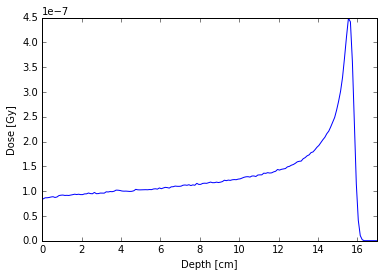

In [6]:
ax = plt.subplot(111)
z = dose.dimensions[2].get_bin_centers()
plt.plot(z, np.squeeze(dose.data['Sum']))
plt.xlabel('Depth [cm]')
plt.ylabel('Dose [Gy]')
ax.set_xlim(xmax=17)

Our second example is the number of tracks passing through a surface as a beam of protons passes through a dipole magnet. The charged particles are deflected by the Lorentz force. Let's investigate what data is available.

In [7]:
ntracks = BinnedResult('../tests/data/SurfaceTracks.csv')

print '{0} [{1}]'.format(ntracks.quantity, ntracks.unit)
print 'Statistics: {0}'.format(ntracks.statistics)
for dim in ntracks.dimensions:
    print '{0} [{1}]: {2} bins'.format(dim.name, dim.unit, dim.n_bins)

# SurfaceTrackCount [None]
Statistics: ['Sum']
X [cm]: 10 bins
Y [cm]: 10 bins
Z [cm]: 1 bins


So the number of tracks is scored on a two-dimensional surface and we can plot this as an image.

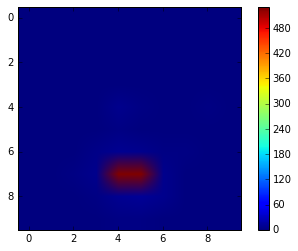

In [8]:
plt.imshow(np.squeeze(ntracks.data['Sum']))
plt.colorbar()